# Classification with NN

In [265]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.python.keras.utils.np_utils import to_categorical

In [266]:
# Base dataframe
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


Function to discretize categorical attributes

In [267]:
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())

        #generate a mapping from the variable's values to the number representation
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new column with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)

    return dataset


In [268]:
# discretize and delete the categorical attributes
df = discretize_data(df,['MaxOrderMonth','Label'])
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TProd              4333 non-null   int64  
 1   DProd              4333 non-null   int64  
 2   MeanProdOrder      4333 non-null   float64
 3   TSale              4333 non-null   float64
 4   MinPSale           4333 non-null   float64
 5   MaxPSale           4333 non-null   float64
 6   MeanSaleOrder      4333 non-null   float64
 7   TRProd             4333 non-null   int64  
 8   MeanPSale          4333 non-null   float64
 9   TOrder             4333 non-null   int64  
 10  SETSaleQta         4333 non-null   float64
 11  SESaleQtaOrder     4333 non-null   float64
 12  MaxOrderMonth_num  4333 non-null   int32  
 13  Label_num          4333 non-null   int32  
dtypes: float64(8), int32(2), int64(4)
memory usage: 473.9 KB


Divide the dataframe to create training and testing sets

In [269]:
label = df.pop('Label_num')
train_set, test_set, train_labels, test_labels = train_test_split(df, label, stratify =label, test_size=0.30)

Oversampling with SMOTE to fix the unbalanced classes.

This creates new data similar to the original one in order to have a number
of samples which is similar (equal) for every class. In this way we introduce more generalization
capability to our classification models

In [270]:
# SMOTE --> balance the number of entries of each class
from imblearn.over_sampling import SMOTE
smote = SMOTE(
    sampling_strategy='not majority',    # resample all classes but the majority one
    k_neighbors=5
)

train_set, train_labels = smote.fit_resample(train_set, train_labels)
test_set, test_labels = smote.fit_resample(test_set, test_labels)

In [271]:
assert(len(train_labels) == len(train_labels))
assert(len(test_set) == len(test_labels))
print(f"{len(train_labels)} training samples")
print(f"{len(test_labels)} test samples")

8103 training samples
3471 test samples


<AxesSubplot:>

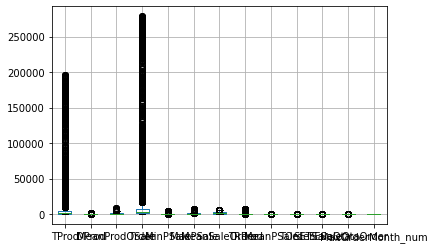

In [272]:
train_set.boxplot()

Rescale the datasets: it's better when using neural networks

In [273]:
from sklearn.preprocessing import MinMaxScaler
cols = train_set.columns
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set.values)
train_set = pd.DataFrame(train_set, columns=cols)
test_set = scaler.fit_transform(test_set.values)
test_set = pd.DataFrame(test_set, columns=cols)

<AxesSubplot:>

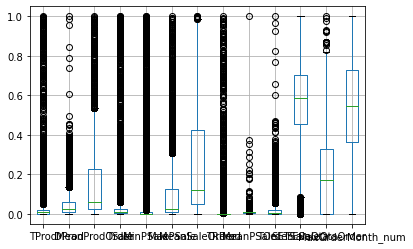

In [274]:
train_set.boxplot()

In [275]:
# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

Create the Neural Network

In [276]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1,13)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 1, 32)             448       
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 1, 32)             1056      
_________________________________________________________________
dropout_39 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 1, 32)             1056      
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_52 (Dense)             (None, 1, 3)            

In [277]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fit the model

In [278]:
history = model.fit(
    train_set,
    train_labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
203/203 [==============================] - 1s 5ms/step - loss: 0.6157 - accuracy: 0.7709 - val_loss: 0.9998 - val_accuracy: 0.2209
Epoch 2/20
203/203 [==============================] - 1s 3ms/step - loss: 0.2521 - accuracy: 0.9011 - val_loss: 0.6171 - val_accuracy: 0.6076

Plot training results

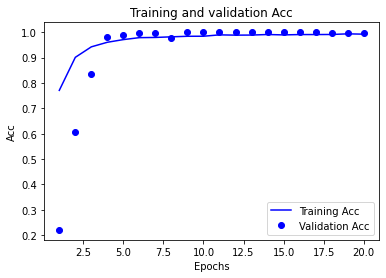

In [279]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'bo', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Make predictions on the test set

In [280]:
test_predictions = model.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)

In [281]:
# Function to create reports on the classification results
from sklearn.metrics import classification_report
classes = ['High_Spend','Low_Spend','Med_Spend']
def report_scores(test_label, test_pred):
    print(
        classification_report(
            test_label,
            test_pred,
            target_names=classes
        )
    )

In [282]:
report_scores(test_labels, test_predictions)

              precision    recall  f1-score   support

  High_Spend       0.98      1.00      0.99      1157
   Low_Spend       0.99      0.97      0.98      1157
   Med_Spend       0.97      0.97      0.97      1157

   micro avg       0.98      0.98      0.98      3471
   macro avg       0.98      0.98      0.98      3471
weighted avg       0.98      0.98      0.98      3471
 samples avg       0.98      0.98      0.98      3471



In [17]:
#test_loss, test_accuracy = model.evaluate(test_set, test_label, batch_size=32, verbose=1)
#print(f"\nTest accuracy: {test_accuracy}")
